In [1]:
from IPython.display import JSON
from google.colab import output
from subprocess import getoutput
import os

def shell(command):
  if command.startswith('cd'):
    path = command.strip().split(maxsplit=1)[1]
    os.chdir(path)
    return JSON([''])
  return JSON([getoutput(command)])
output.register_callback('shell', shell)

In [2]:
#@title Colab Shell
%%html
<div id=term_demo></div>
<script src="https://code.jquery.com/jquery-latest.js"></script>
<script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
<link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
<script>
  $('#term_demo').terminal(async function(command) {
      if (command !== '') {
          try {
              let res = await google.colab.kernel.invokeFunction('shell', [command])
              let out = res.data['application/json'][0]
              this.echo(new String(out))
          } catch(e) {
              this.error(new String(e));
          }
      } else {
          this.echo('');
      }
  }, {
      greetings: 'Welcome to Colab Shell',
      name: 'colab_demo',
      height: 250,
      prompt: 'colab > '
  });

In [5]:
import random
import numpy as np
import gym
import torch


from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,"/content/drive/MyDrive/Colab Notebooks")

from dqn.agent import DQNAgent
from dqn.replay_buffer import ReplayBuffer
from dqn.wrappers import *

if __name__ == "__main__":

    hyper_params = {
        "seed": 42,  # which seed to use
        "env": "PongNoFrameskip-v4",  # name of the game
        "replay-buffer-size": int(5e3),  # replay buffer size
        "learning-rate": 1e-4,  # learning rate for Adam optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(1e6),  # total number of steps to run the environment for
        "batch-size": 256,  # number of transitions to optimize at the same time
        "learning-starts": 10000,  # 10000 number of steps before learning starts
        "learning-freq": 5,  # number of iterations between every optimization step
        "use-double-dqn": True,  # use double deep Q-learning
        "target-update-freq": 1000,  # 1000 number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.01,  # e-greedy end threshold
        "eps-fraction": 0.1,  # fraction of num-steps
        "print-freq": 10,
    }

    np.random.seed(hyper_params["seed"])
    random.seed(hyper_params["seed"])

    assert "NoFrameskip" in hyper_params["env"], "Require environment with no frameskip"
    env = gym.make(hyper_params["env"])
    env.seed(hyper_params["seed"])

    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)
    env = FireResetEnv(env)
    # TODO Pick Gym wrappers to use
    #
    #
    #
    env = WarpFrame(env)
    env = PyTorchFrame(env)
    env = gym.wrappers.Monitor(env, "path/to/store/recordings", force = True)

    replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])

    # TODO Create dqn agent
    # agent = DQNAgent( ... )
    agent = DQNAgent(env.observation_space, env.action_space, replay_buffer, hyper_params["use-double-dqn"], hyper_params["learning-rate"], hyper_params["batch-size"], hyper_params["discount-factor"])

    eps_timesteps = hyper_params["eps-fraction"] * float(hyper_params["num-steps"])
    episode_rewards = [0.0]
    losses = []

    state = env.reset()
    for t in range(hyper_params["num-steps"]):
        fraction = min(1.0, float(t) / eps_timesteps)
        eps_threshold = hyper_params["eps-start"] + fraction * (
            hyper_params["eps-end"] - hyper_params["eps-start"]
        )
        sample = random.random()
        # TODO
        #  select random action if sample is less equal than eps_threshold
        # take step in env
        # add state, action, reward, next_state, float(done) to reply memory - cast done to float
        # add reward to episode_reward

        action = agent.act(state, sample, eps_threshold)
        next_state, reward, done, info = env.step(action)
        # print(action)
        done = float(done)
        # print(action.item())
        agent.memory.add(state, action, reward, next_state, done)
        state = next_state

        episode_rewards[-1] += reward
        if done:
            state = env.reset()
            episode_rewards.append(0.0)

        if (
            t > hyper_params["learning-starts"]
            and t % hyper_params["learning-freq"] == 0
        ):
            losses.append(agent.optimise_td_loss())

        if (
            t > hyper_params["learning-starts"]
            and t % hyper_params["target-update-freq"] == 0
        ):
            agent.update_target_network()

        num_episodes = len(episode_rewards)

        if (
            done
            and hyper_params["print-freq"] is not None
            and len(episode_rewards) % hyper_params["print-freq"] == 0
        ):
            mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
            print("********************************************************")
            print("steps: {}".format(t))
            print("episodes: {}".format(num_episodes))
            print("mean 100 episode reward: {}".format(mean_100ep_reward))
            print("% time spent exploring: {}".format(int(100 * eps_threshold)))
            print("********************************************************")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1, 84, 84)
(1, 84, 84)
********************************************************
steps: 7847
episodes: 10
mean 100 episode reward: -20.6
% time spent exploring: 92
********************************************************
********************************************************
steps: 17218
episodes: 20
mean 100 episode reward: -20.4
% time spent exploring: 82
********************************************************
********************************************************
steps: 26354
episodes: 30
mean 100 episode reward: -20.4
% time spent exploring: 73
********************************************************
********************************************************
steps: 36446
episodes: 40
mean 100 episode reward: -20.3
% time spent exploring: 63
********************************************************
********************************************************

In [6]:
torch.save(agent.policy_net, "path/to/store/recordings/policy_net.pb")
torch.save(agent.target_net, "path/to/store/recordings/target_net.pb")

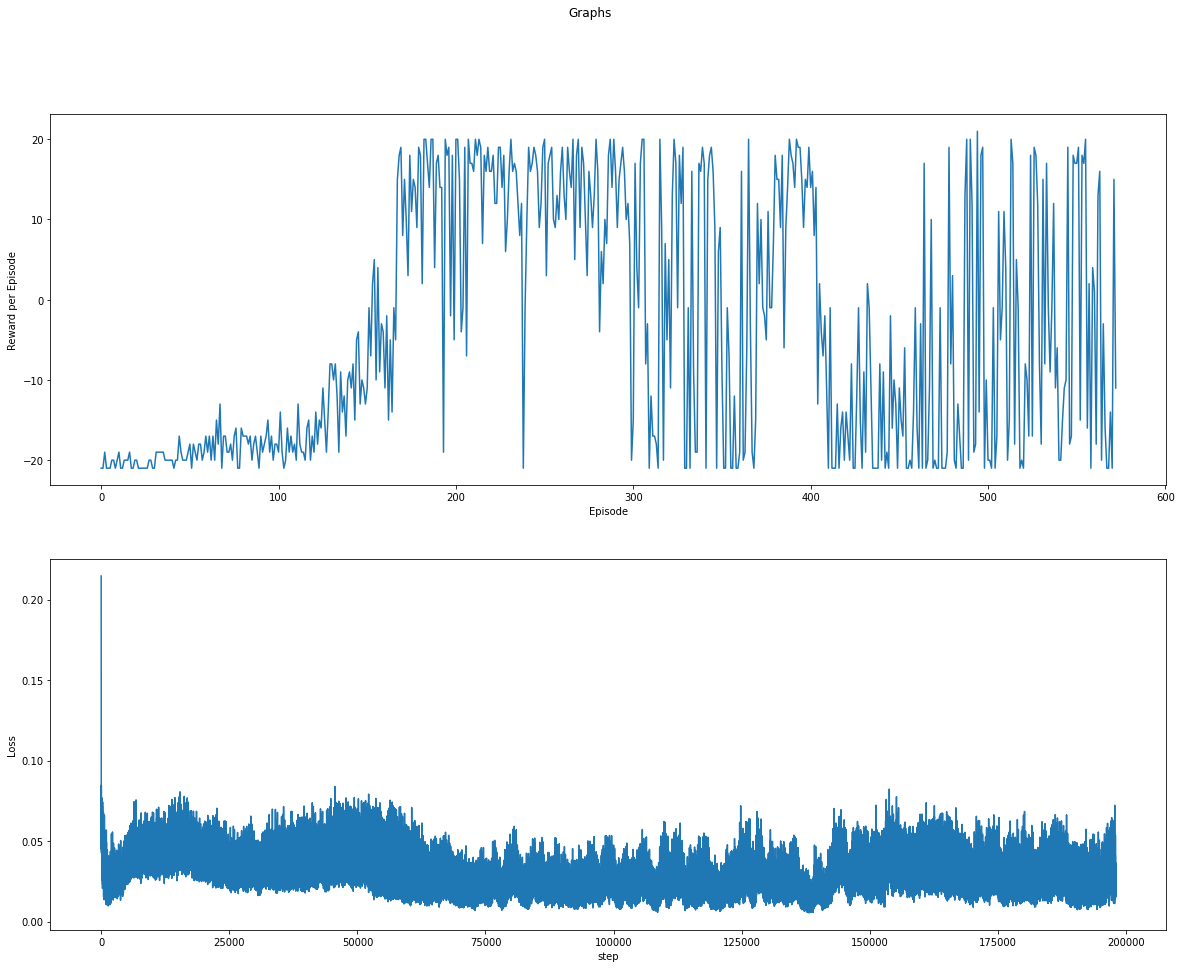

In [8]:
import matplotlib.pyplot as plt

# figure, plots = plt.figure(figsize=(17, 15))
figure, plots = plt.subplots(2, 1, figsize=(20, 15))
# grid = figure.add_gridspec(1, 1)
# plots = grid.subplots()
# plots = subplots()

figure.suptitle("Graphs")

plots[0].set_ylabel("Reward per Episode")
plots[0].set_xlabel("Episode")
plots[0].plot(np.arange(len(episode_rewards)), episode_rewards)
plots[1].set_ylabel("Loss")
plots[1].set_xlabel("step")
plots[1].plot(np.arange(len(losses)), losses)
plt.savefig("path/to/store/recordings/graphs.png")
plt.show()

In [9]:
state = env.reset()
# for t in range(hyper_params["num-steps"]):
for t in range(100000):
    # fraction = min(1.0, float(t) / eps_timesteps)
    env.render()
    fraction = 1.0
    eps_threshold = hyper_params["eps-start"] + fraction * (
        hyper_params["eps-end"] - hyper_params["eps-start"]
    )
    sample = random.random()
    # TODO
    #  select random action if sample is less equal than eps_threshold
    # take step in env
    # add state, action, reward, next_state, float(done) to reply memory - cast done to float
    # add reward to episode_reward

    action = agent.act(state, sample, eps_threshold)
    next_state, reward, done, info = env.step(action)
    # print(action)
    done = float(done)
    # print(action.item())
    agent.memory.add(state, action, reward, next_state, done)
    state = next_state

    episode_rewards[-1] += reward
    if done:
        state = env.reset()
        episode_rewards.append(0.0)

    if (
        t > hyper_params["learning-starts"]
        and t % hyper_params["learning-freq"] == 0
    ):
        # losses.append(agent.optimise_td_loss())
        agent.optimise_td_loss()

    if (
        t > hyper_params["learning-starts"]
        and t % hyper_params["target-update-freq"] == 0
    ):
        agent.update_target_network()

    num_episodes = len(episode_rewards)

    if (
        done
        and hyper_params["print-freq"] is not None
        and len(episode_rewards) % hyper_params["print-freq"] == 0
    ):
        mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
        print("********************************************************")
        print("steps: {}".format(t))
        print("episodes: {}".format(num_episodes))
        print("mean 100 episode reward: {}".format(mean_100ep_reward))
        print("% time spent exploring: {}".format(int(100 * eps_threshold)))
        print("********************************************************")

Error: ignored